## Keras CNN Exploration

### Load Libraries

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.notebook_api.model_loader import ModelScenario

2024-11-30 08:20:17.366351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data
load data from data loader and inspect the shape of the features which appears to be variable

In [2]:
model_data_loader = ModelDataLoader('005')
model_data_loader_df = model_data_loader.df
features = model_data_loader.get_mfcc()
labels_series = model_data_loader.df['label']
#array of feature shapes
feature_shapes = [feature.shape[1] for feature in features]
print("features shape distribution")
print(pd.Series(feature_shapes).value_counts())
print("total records: ", len(features))

features shape distribution
2582    13510
2585    10580
2812      583
1         460
1293      357
        ...  
609         1
490         1
242         1
528         1
873         1
Name: count, Length: 132, dtype: int64
total records:  25947


In [3]:
#verify matching length
len(labels_series) , len(features)

(25947, 25947)

### Define Filter Based on features

In [4]:
# currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training 
MFCC_LENGTH_CUTOFF = 2582
#array of indexes matching a predicate 
in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
print("normalized length: ",len(in_scope_feature_indexes))

normalized length:  24679


### Encode Labels
assign a numerical index to each string label, then one hot encode the label dataset 

In [5]:
labels_series.value_counts()

label
rock                  7305
experimental          4848
electronic            4114
hiphop                3488
folk                  1286
pop                   1038
classical              997
jazz                   653
international          629
instrumental           483
oldtime / historic     373
country                294
spoken                 270
soulrnb                 82
blues                   79
easy listening           8
Name: count, dtype: int64

In [6]:
#pick subset of labels that are more intuitively representative of genre 
#genres like pop which are ambiguous are removed 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
#optain the indexes of label series wher the label is in the list 
in_scope_label_indexes = np.array(
    (labels_series[
                    labels_series
                        .apply(lambda x: True if x in  in_scope_labels else False)
                ]
                        .index
    )
)
gtzan_indexes = np.array(
    (model_data_loader_df[
                    model_data_loader_df['dataset']
                        .apply(lambda x: True if x == 'gtzan' else False)
                ]
                        .index
    )
)

#combine filter for the in scope labels with the same for in scope features 
in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]

print("Row Count after label based filter: ", len(in_scope_label_indexes))
print("Final Row count after label and feature filter: ", len(in_scope_indexes))

Row Count after label based filter:  16851
Final Row count after label and feature filter:  16011


In [7]:
in_scope_label_series = labels_series.iloc[in_scope_indexes]
unique_label_names = in_scope_label_series.unique()
unique_label_count = len(in_scope_label_series.unique())
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index  


int_to_label_map = {v: k for k, v in label_to_int_map.items()}

#numerical_labels = labels_series.map(label_to_int_map)
numerical_labels = in_scope_label_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))

#put to list and reshape again 
#not needed in current implementation
#encoded_labels_array = [label.reshape((unique_label_count,1)) for label in encoded_labels.numpy()]
print("Unique label count: ", unique_label_count)
print("label data count " , len(encoded_labels))

Unique label count:  6
label data count  16011


In [8]:
in_scope_label_series.value_counts()

label
rock          7184
electronic    3899
hiphop        3316
classical      869
jazz           549
country        194
Name: count, dtype: int64

### filter, truncate, reshape features
iterate through the filtered features and build a vector representation appropriate for the CNN input

In [9]:
#truncate to consistent length while reshaping 
reshaped_features = []
feature_array = []
for feature in features[in_scope_indexes]:
    mfcc = [] 
    for vector in feature: 
        mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
        mfcc_reshaped = np.array(mfcc)
    feature_array.append(mfcc_reshaped)
    reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,13,1)))

### Train Test Split

In [17]:
#smote implementation
def get_train_test_data_with_smote(feature_array, numerical_labels, test_size, unique_label_names):
    #instantiate initial split
    X_train_, X_test_, y_train_, y_test_ = train_test_split(np.array(feature_array), np.array(numerical_labels), test_size=test_size, random_state=42, stratify =np.array(numerical_labels) )
    smote = SMOTE(random_state=42)
    
    X_train_balance_index, y_train_balanced = smote.fit_resample(np.array(list(range(0,len(X_train_)))).reshape(-1, 1), y_train_)
    #apply smote to the training data
    X_train = X_train_[np.array(X_train_balance_index.reshape(X_train_balance_index.shape[0]))]
    #rshape
    X_train =X_train.reshape((len(X_train),MFCC_LENGTH_CUTOFF,13,1))

    #encoded training data post smote  post smote
    y_train = np.array(tf.one_hot(indices = y_train_balanced, depth = len(unique_label_names)))

    #to adjust shapes for smote 
    #this should be test 
    X_test = X_test_.reshape(X_test_.shape[0], X_test_.shape[2],X_test_.shape[1],1)

    y_test = np.array(tf.one_hot(indices = y_test_, depth = len(unique_label_names)))
    return X_train, X_test, y_train, y_test
  

In [19]:
#generate train and test with stratification for equal label distribution across train and test 
TEST_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )
 
#X_train, X_test, y_train, y_test = get_train_test_data_with_smote(feature_array, numerical_labels, TEST_SIZE,  unique_label_names)



In [12]:
#original split
X_train.shape, y_train.shape

((12808, 2582, 13, 1), (12808, 6))

### Define CNN model

In [13]:
model = keras.Sequential(layers=[
    #https://www.youtube.com/watch?v=dOG-HxpbMSw
    #convulution 1
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 2
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 3
    keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #flatten and feed into dense layer with dropiut
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.3),
    #predictions
    keras.layers.Dense(unique_label_count, activation=keras.activations.softmax)
        
    ])
cce = keras.losses.categorical_crossentropy

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

In [187]:
#note this currently only works after training
#To do figure out how to build model prior to training to inspect it's architectuer
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 2580, 11, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 1290, 6, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 1290, 6, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 1288, 4, 32)       9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 644, 2, 32)        0         
 ng2D)                                                           
                                                      

### Train Model

In [14]:
#configuration
#BATCH_SIZE = 128
BATCH_SIZE = 64
#BATCH_SIZE = 32
EPOCHS = 50
#EPOCHS = 2
#EPOCHS = 2

consider stratified k-fold: https://www.kaggle.com/code/chayannaskar26/stratified-k-fold-cnn
Or smote for imbalance

Epoch 1/50
161/161 [==============================] - 140s 857ms/step - loss: 0.9971 - accuracy: 0.6390 - val_loss: 0.9705 - val_accuracy: 0.6659
Epoch 2/50
161/161 [==============================] - 128s 793ms/step - loss: 0.8190 - accuracy: 0.7101 - val_loss: 0.7925 - val_accuracy: 0.7240
Epoch 3/50
161/161 [==============================] - 124s 771ms/step - loss: 0.7531 - accuracy: 0.7394 - val_loss: 0.7817 - val_accuracy: 0.7217
Epoch 4/50
161/161 [==============================] - 125s 776ms/step - loss: 0.7172 - accuracy: 0.7469 - val_loss: 0.7682 - val_accuracy: 0.7279
Epoch 5/50
161/161 [==============================] - 125s 777ms/step - loss: 0.6642 - accuracy: 0.7744 - val_loss: 0.7344 - val_accuracy: 0.7428
Epoch 6/50
161/161 [==============================] - 128s 794ms/step - loss: 0.6138 - accuracy: 0.7840 - val_loss: 0.7134 - val_accuracy: 0.7447
Epoch 7/50
161/161 [==============================] - 140s 868ms/step - loss: 0.5716 - accuracy: 0.7954 - val_loss: 0.8143 -

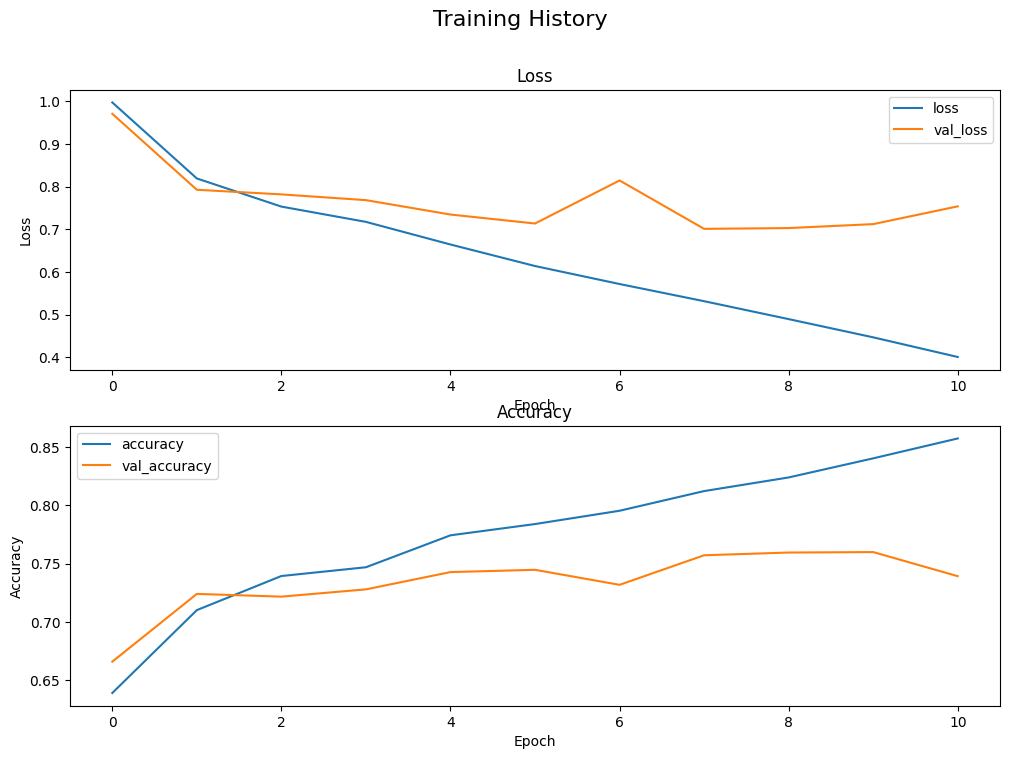

In [15]:
# Train the model
#following reference: https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification/notebook
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    #monitor='val_accuracy',
    min_delta = 0,
    patience=3, 
    mode='auto',
    restore_best_weights=True
    )
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

101/101 [==============================] - 14s 136ms/step


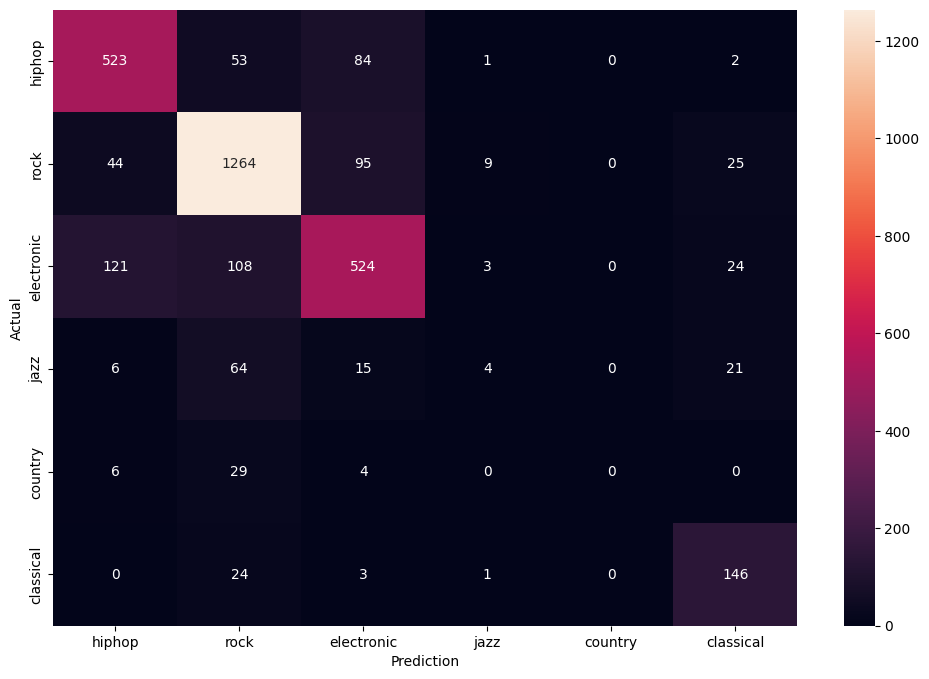

In [16]:
#validation 
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
#remap the ints to string names 
label_names = [int_to_label_map[int_label] for int_label in np.unique(numerical_labels)]
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [27]:
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_predicted, target_names=label_names))


Classification Report:
              precision    recall  f1-score   support

      hiphop       0.75      0.79      0.77       663
        rock       0.82      0.88      0.85      1437
  electronic       0.72      0.67      0.70       780
        jazz       0.22      0.04      0.06       110
     country       0.00      0.00      0.00        39
   classical       0.67      0.84      0.74       174

    accuracy                           0.77      3203
   macro avg       0.53      0.54      0.52      3203
weighted avg       0.74      0.77      0.75      3203

